# ldcpy Tutorial Notebook

In [1]:
# Add ldcpy root to system path
import sys
sys.path.insert(0,'../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2
import ldcpy

#display the plots in this notebook
%matplotlib inline

# Table of contents
1. [Overview](#overview)
2. [Loading Datasets and Viewing Metadata](#loadingdata)
    1. [Printing Statistics](#printstats)
3. [Spatial Plots](#spatial)
    1. [Basic Spatial Plot](#basic_spatial)
    2. [Spatial Subsetting](#spatial_subsetting)
    3. [Spatial Comparisons](#spatial_comparison)
    4. [Unusual Values](#unusual_values)
    5. [Other Spatial Plots](#other_spatial)
4. [Time Series Plots](#timeseries)
    1. [Basic Time-Series Plot](#basic_time)
    2. [Using group_by](#group_by)
    2. [Histogram](#histogram)
    2. [Other Time-Series Plots](#other_time)
    2. [Time-Series Subsetting](#subset_time)

## Overview <a name="overview"></a>

This notebook provides an introduction to opening datasets, viewing metadata, and plotting  both time-series and spatial plots of the datasets and related metrics using the ldcpy package. Plot examples start out with the essential arguments, and subsequent examples will explore the various plotting options that are available. For information about installation, see [these instructions](https://ldcpy.readthedocs.io/en/latest/installation.html), and for information about usage, see the API reference [here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot).

## Loading Datasets and Viewing Metadata <a name="loadingdata"></a>

The first step in plotting data is to load the datasets we are interested in plotting, to do this we use ldcpy.open_datasets(). As can be seen below, this function requires three arguments:
    
    varnames: the variable(s) of interest to combine across files
    list_of_files: a list of files (either relative or absolute paths)
    labels: corresponding list of names for each file. 
    
Additionally, any arguments to xarray.open_mfdatasets can be specified as kwargs (e.g., chunk size) - "chunks" may be important for large data (see large data example notebook for more information).  

We use three different timeseries datasets in these examples, one containing TS data (ds), one containing PRECT data (ds2), and a 3d dataset containing T data (ds3). These datasets are collections of variable data in several different netCDF files, which are given names in the second parameter to the ldcpy.open_datasets function. These names can be whatever you want, but they should be informative because the names will be used to select the appropriate dataset later and as part of plot titles.

In [2]:
# ds contains TS data
ds = ldcpy.open_datasets(["TS"],['../../../data/cam-fv/orig.TS.100days.nc', 
                                 '../../../data/cam-fv/zfp1.0.TS.100days.nc', 
                                 '../../../data/cam-fv/zfp1e-1.TS.100days.nc'],
                         ['orig', 'zfpA1.0', 'zfpA1e-1'])
ds2 = ldcpy.open_datasets(["PRECT"],['../../../data/cam-fv/orig.PRECT.60days.nc', 
                                     '../../../data/cam-fv/zfp1e-7.PRECT.60days.nc', 
                                     '../../../data/cam-fv/zfp1e-11.PRECT.60days.nc'],
                         ['orig', 'zfpA1.0', 'zfpA1e-1'])
ds3 = ldcpy.open_datasets(["T"],['../../../data/cam-fv/cam-fv.T.3months.nc',
                                 '../../../data/cam-fv/c.fpzip.cam-fv.T.3months.nc'],
                          ['orig', 'comp'], chunks={'time': 1})

chucks set to (default) {'time', 50}
dataset size in GB 0.07

chucks set to (default) {'time', 50}
dataset size in GB 0.04

chunks set to (by user)  {'time': 1}
dataset size in GB 0.04



Printing a dataset reveals the dimension names, sizes, datatypes and values, among other metadata. The dimensions and the length of each dimension are listed at the top of the output. Coordinates list the dimensions vertically, along with the data type of each dimension and the coordinate values of the dimension (for example, we can see that the 192 latitude data points are spaced evenly between -90 and 90). Data variables lists all the variables available in the dataset. Most of them will not be of concern when plotting the data, but one of the variables in this dataset, "T", is an array containing the values we are interested in (note that it has the required "lat", "lon", and "time" dimensions, as well as a "lev" dimension indicating that this is a 3D dataset with values at several altitudes, and finally the "collection" dimension, along which we concatenated several datasets together.

In [4]:
#look at contents of ds3
ds3

<xarray.Dataset>
Dimensions:       (collection: 2, ilev: 31, lat: 192, lev: 30, lon: 288, nbnd: 2, slat: 191, slon: 288, time: 3)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 1920-02-01 00:00:00 ... 1920-04-01 00:00:00
  * lat           (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * slat          (slat) float64 -89.53 -88.59 -87.64 ... 87.64 88.59 89.53
  * slon          (slon) float64 -0.625 0.625 1.875 3.125 ... 355.6 356.9 358.1
  * lon           (lon) float64 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
  * collection    (collection) <U4 'orig' 'comp'
Dimensions without coordinates: nbnd
Data variables:
    ntrn          int32 1
    n2ovmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nbsec         int32 0
    gw            (lat) float64 dask.array<chunksize=(192,), meta=np.ndarray>
    wnummax       (lat) int32 dask.array<chunksize=(192,), meta=np.ndarray>
    sol_tsi       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ntrm          int32 1
    ch4vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    nsteph        (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    date          (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nscur         (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    P0            float64 1e+05
    time_written  (time) |S8 dask.array<chunksize=(1,), meta=np.ndarray>
    date_written  (time) |S8 dask.array<chunksize=(1,), meta=np.ndarray>
    f11vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    co2vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ntrk          int32 1
    nbdate        int32 19200101
    hybi          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    hyam          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    hyai          (ilev) float64 dask.array<chunksize=(31,), meta=np.ndarray>
    f12vmr        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    ndbase        int32 0
    w_stag        (slat) float64 dask.array<chunksize=(191,), meta=np.ndarray>
    time_bnds     (time, nbnd) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    nlon          (lat) int32 dask.array<chunksize=(192,), meta=np.ndarray>
    nsbase        int32 0
    mdt           int32 1800
    hybm          (lev) float64 dask.array<chunksize=(30,), meta=np.ndarray>
    datesec       (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    ndcur         (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    T             (collection, time, lev, lat, lon) float32 dask.array<chunksize=(1, 1, 30, 192, 288), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    title:            UNSET
    logname:          mickelso
    host:             ys0219
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...
    history:          Thu Jul  9 14:15:11 2020: ncks -d time,0,2,1 cam-fv.T.6...
    NCO:              netCDF Operators version 4.7.9 (Homepage = http://nco.s...

### Printing Statistics <a name="printstats"></a>

The print_stats function can be used to compute and compare the overall statistics for two datasets. To use this function, four arguments are required. In order, they are: 

    ds      - the collection of datasets read in from open_datasets
    varname - the variable name we want to get statistics for (in this case 'TS)
    c0      - the label of one particular dataset in the collection we are interested in ('orig')
    c1      - and the label of another dataset we want to compare it with ('zfpA1.0'). 

Additionally, one optional argument can be specified:

    time    - the time slice of data we want to get metrics for (default 0, which is the first slice)

In [5]:
ldcpy.print_stats(ds, 'TS', 'orig', 'zfpA1.0')

Comparing orig data (c0) to zfpA1.0 data (c1)
           mean c0 :  274.7137027669836
           variance c0 :  534.0058139367205
           standard deviation c0 :  23.10856581306422
           mean c1 :  274.707935474537
           variance c1 :  533.680828155477
           standard deviation c1 :  23.10153302608892
           max diff :  0.00726318359375
           min diff :  0.00726318359375
           mean squared diff :  3.326166216415184e-05
           mean diff :  0.00576729244656033
           mean abs diff :  0.05852021166571864
           root mean squared diff :  0.07527297655350516
           pearson correlation coefficient :  0.9999947706571547
           covariance :  533.8405046664303
           ks p value :  0.0


We can use the ldcpy.DatasetMetrics class to obtain a metrics on a dataset. To do so, we grab the data we want a metric from, using standard xarray notation: 

    my_data = ds['TS'].sel(collection='orig')
    
this line selects 'TS' data, and selects the dataset named 'orig'. 

Then we create a DatasetMetrics object using the data and a list of dimensions that we want to aggregate the data along (in this case, time).

    ds_metrics = ldcpy.DatasetMetrics(my_data, ["time"])

When we call the get_metric() method on this class, a metric will be computed across each of these. (If we wanted a time-series plot, then we would aggregate along the "lat" and "lon" dimensions.

    my_data_mean_across_time = ds_metrics.get_metric("mean")

A complete list of metrics is available [here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot).

In [6]:
my_data = ds['TS'].sel(collection='orig')

In [6]:
ds_metrics = ldcpy.DatasetMetrics(my_data, ["time"])
this_mean = ds_metrics.get_metric("mean")
this_mean

<xarray.DataArray 'TS' (lat: 192, lon: 288)>
dask.array<mean_agg-aggregate, shape=(192, 288), dtype=float64, chunksize=(192, 288), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon         (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    collection  <U8 'orig'

## Spatial Plots <a name="spatial"></a>

### A Basic Spatial Plot <a name="basic_spatial"></a>

The most basic usage of the ldcpy.plot() function requires:

    ds      - the collection of datasets read in from open_datasets
    varname - the variable name we want to get statistics for
    c0      - the label of one particular dataset we are interested in
    metric  - the name of the metric of interest
    
There are several optional arguments as well, that will be used in subsequent plots. These options include:

    c1, group_by, scale, metric_type, plot_type, transform, subset, lat, lon, lev, color, standardized_error, quantile, start, end
    
A full explanation of each optional variable is available in the documentation [here](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot). By default, a spatial plot of this data is created. The title of the plot contains the name of the dataset, the variable of interest, and the metric that is plotted. The following plot shows the mean TS (temperature) value over time at each point in the original dataset:

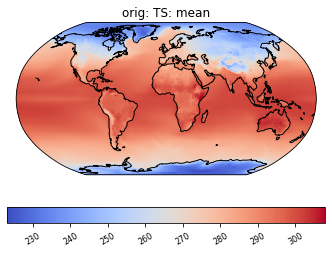

In [7]:
ldcpy.plot(ds, "TS", c0='orig', metric='mean')

We can also plot different metrics, such as the standard deviation at each grid point over time, or change the color scheme (for a full list of metrics and color schemes, see the [documentation](https://ldcpy.readthedocs.io/en/latest/api.html#ldcpy.plot.plot)):

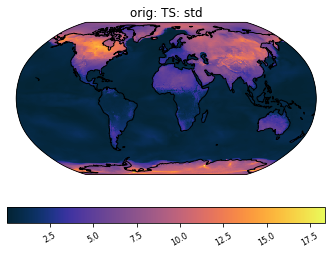

In [8]:
ldcpy.plot(ds, "TS", c0='orig', metric='std', color="cmo.thermal")

### Spatial Subsetting <a name="spatial_subsetting"></a>

Plotting the metric of a subset of the data (e.g., not all of the time slices) is possible using the subset keyword:

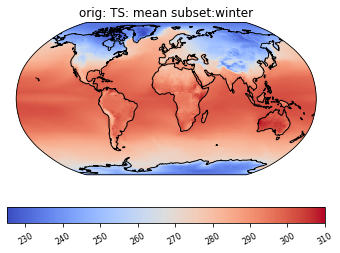

In [9]:
ldcpy.plot(ds, "TS", c0='orig', metric='mean', subset="winter")

It is also possible to plot metrics for a subset of the time slices by specifying the start and end indices of the time we are interested in. This command creates a spatial plot of the mean TS values in "orig" for the first five days of data:

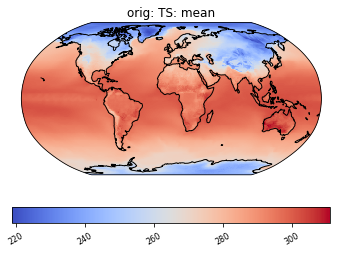

In [10]:
ldcpy.plot(ds, "TS", c0='orig', metric='mean', start=0, end=5)

Finally, for a 3D dataset, we can specify which vertical level to view using the "lev" keyword, which selects the nearest level to the lev value specified (by default, lev=0):

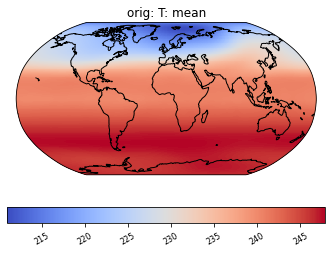

In [11]:
ldcpy.plot(ds3, "T", c0='orig', metric='mean', lev='0')

### Spatial Comparisons <a name="spatial_comparison"></a>

If we want a side-by-side comparison of two datasets, we need to specify an additional dataset using the c1 argument, and a plot_type of "spatial_comparison". This plot shows the mean TS value over time at each point in both the c0 (original) and c1 (compressed with zfp, tolerance 1.0) datasets:

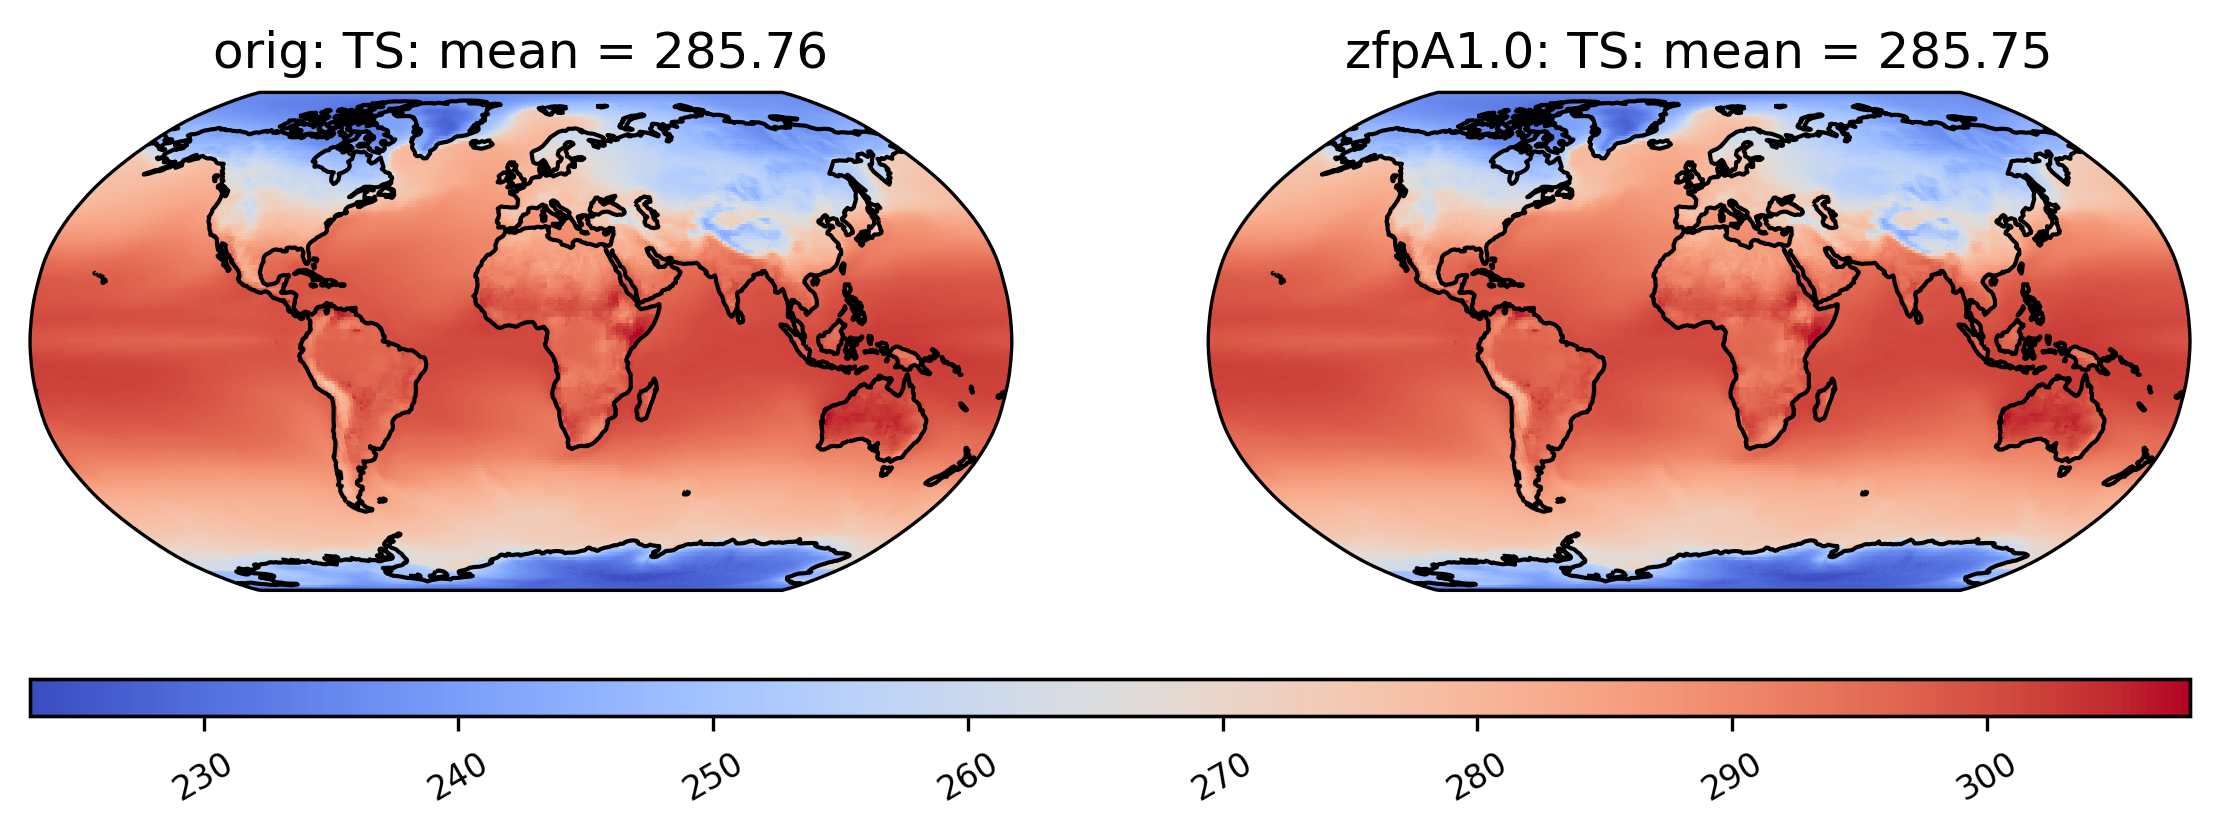

In [12]:
ldcpy.plot(ds, "TS", c0='orig', metric='mean', c1='zfpA1.0', plot_type="spatial_comparison")

It is possible to compare two differemt compressed datasets side by side as well, by simply using a different dataset name for c0:

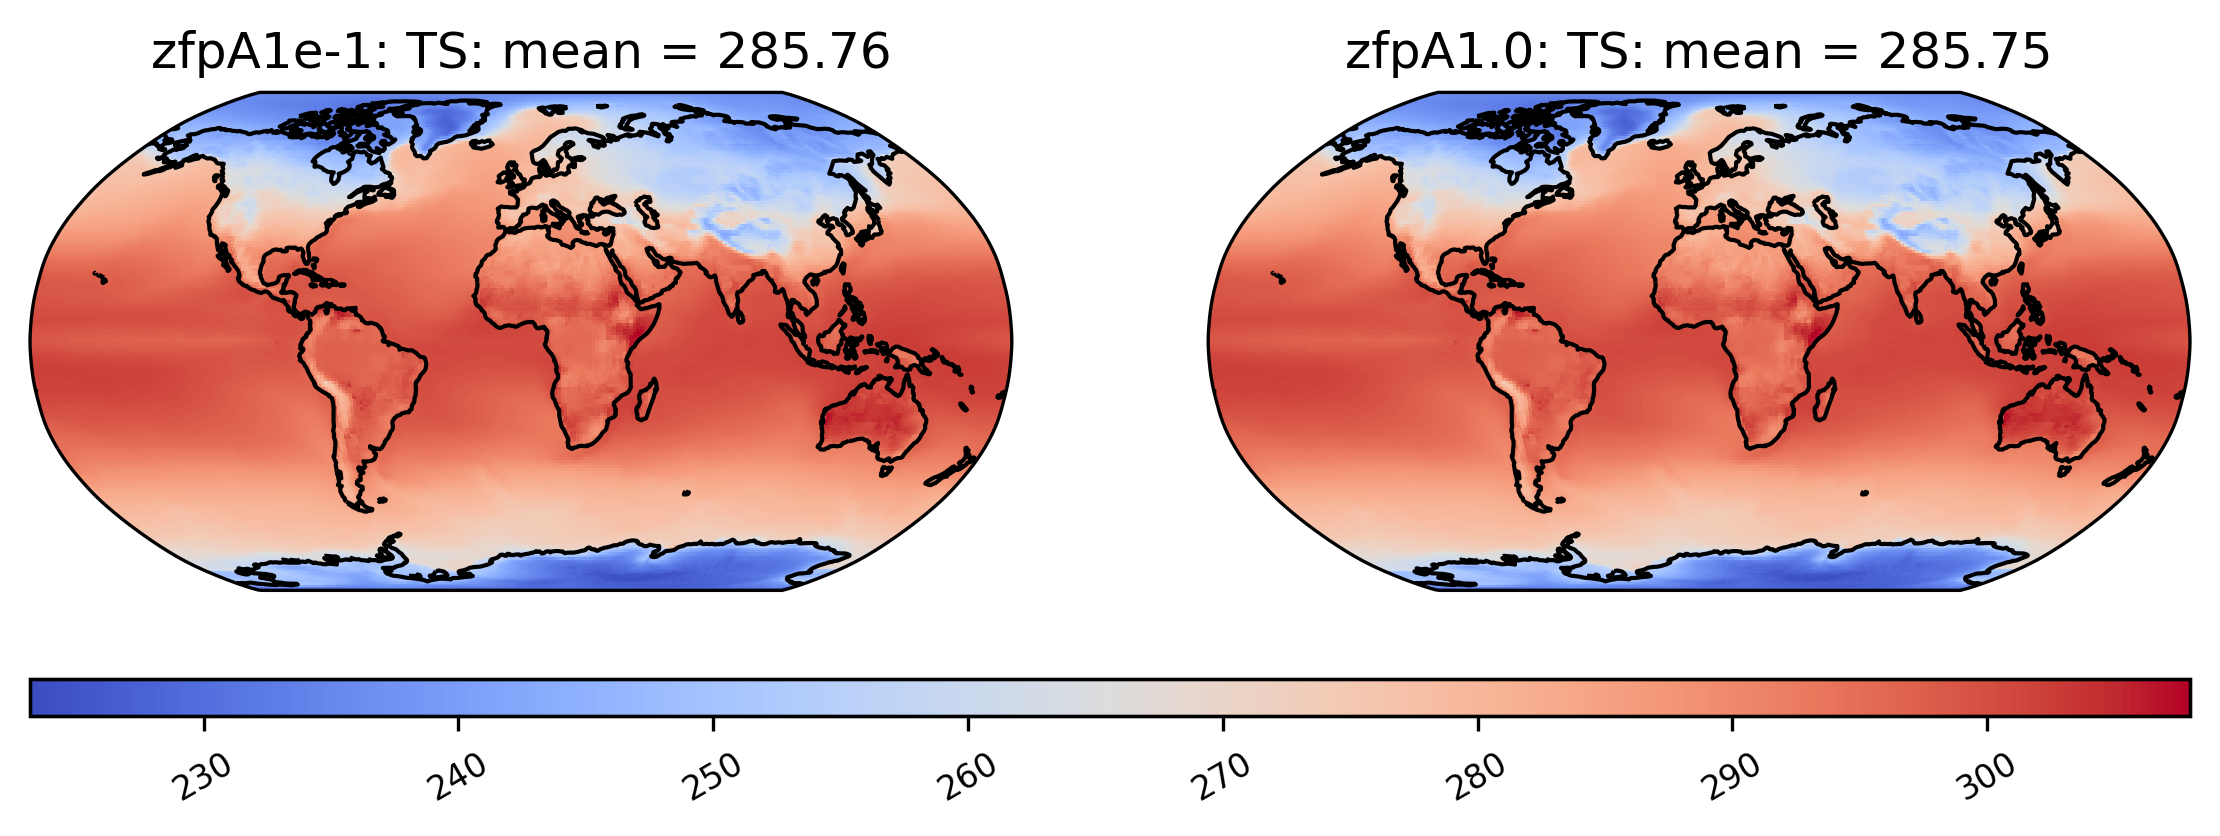

In [13]:
ldcpy.plot(ds, "TS", c0='zfpA1e-1', metric='mean', c1='zfpA1.0', plot_type="spatial_comparison")

### Unusual Values (inf, -inf, NaN) <a name="unusual_values"></a>

Some metrics result in values that are +/- infinity, or NaN (likely resulting from operations like 0/0 or inf/inf). NaN values are plotted in gray, infinity is plotted in white, and negative infinity is plotted in black (regardless of color scheme). If infinite values are present in the plot data, arrows on either side of the colorbar are shown to indicate the color for +/- infinity. This plot shows the log of the ratio of the odds of positive rainfall over time in the compressed and original output, log(odds_positive compressed/odds_positive original). Here we are suppressing all of the divide by zero warnings for aesthetic reasons.  This statistic showcases some interesting plot features:

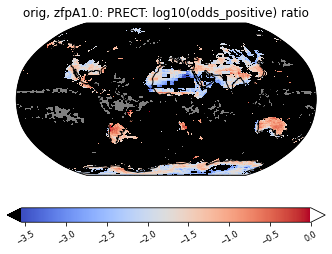

In [14]:
import warnings
warnings.filterwarnings('ignore')

ldcpy.plot(ds2, 'PRECT', c0='orig', c1='zfpA1.0', metric='odds_positive', metric_type="ratio", transform="log")

If all values are NaN, the colorbar is not shown. Instead, a legend is shown indicating the gray color of NaN values, and the whole plot is colored gray. (If all values are infinite, then the plot is displayed normally with all values either black or white). Because the example dataset only contains 60 days of data, the deseasonalized lag-1 values and their variances are all 0, and so calculating the correlation of the lag-1 values will involve computing 0/0 = NaN:

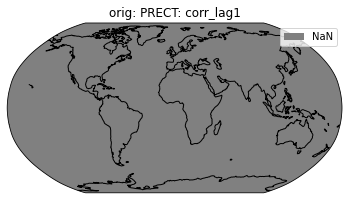

In [15]:
ldcpy.plot(ds2, "PRECT", c0="orig", metric="corr_lag1")

### Other Spatial Plots <a name="other_spatial"></a>

Additionally, there are a number of ways to compare datasets in addition to a side-by-side comparison. By specifying the metric_type, we can plot the diff or the ratio between the metrics in two datasets. The plot below shows the ratio of the zfp 1.0 standard deviation values over the original values:


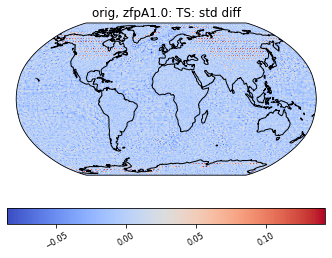

In [15]:
ldcpy.plot(ds, 'TS', c0='orig', c1='zfpA1.0', metric="std", metric_type="diff")

Sometimes, we may want to compute a metric on the difference between two datasets. For instance, the zscore metric calculates the zscore at each point under the null hypothesis that the true mean is zero, so using the "metric_of_diff" metric_type calculates the zscore of the diff between two datasets (to find the values that are significantly different between the two datasets). The zscore metric in particular gives additional information about the percentage of significant gridpoints in the plot title:

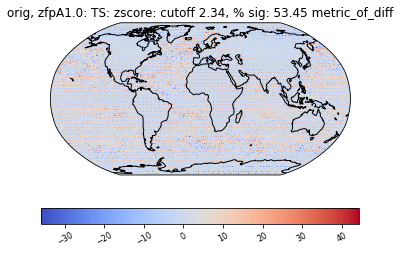

In [16]:
ldcpy.plot(ds, 'TS', c0='orig', metric='zscore', c1="zfpA1.0", metric_type="metric_of_diff")

## Time-Series Plots <a name="timeseries"></a>

We may also plot a time-series plot of the metrics by changing the plot_type, to calculate the metric values across space rather than across time:

### Basic Time-Series Plot <a name="basic_time"></a>


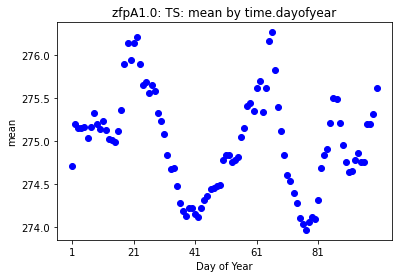

In [17]:
ldcpy.plot(ds, "TS", c0='zfpA1.0', metric='mean', plot_type="time_series", group_by="time.dayofyear")

### Using the group_by keyword <a name="group_by"></a>

To group the data by time, use the group_by keyword. This plot shows the mean standard deviation over all latitude and longitude points for each month.  Note that this plot is not too interesting for our sample data, which has 100 days of data.

ValueError: Maximum allowed size exceeded

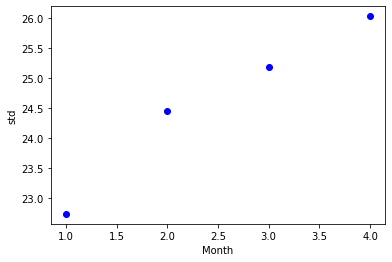

In [18]:
ldcpy.plot(ds, "TS", c0='orig', metric='std', plot_type="time_series", group_by="time.month")

### Histograms <a name="histogram"></a>

We can also view a histogram of the time-series data by changing the plot_type to histogram:

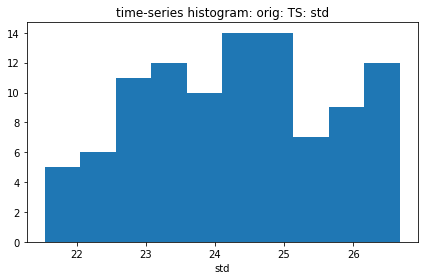

In [19]:
ldcpy.plot(ds, "TS", c0='orig', metric='std', plot_type="histogram")

### Other Time-Series Plots <a name="other_time"></a>

A second dataset can be specified using the c1 keyword, just as in the spatial plots. The metric_type keyword can also be used in the same way. This plot shows the mean differences between the compressed and original standard deviation values:

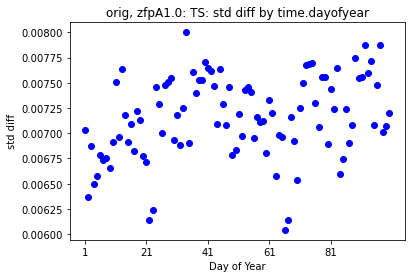

In [20]:
ldcpy.plot(ds, "TS", c0='orig', metric='std', plot_type="time_series", group_by="time.dayofyear", c1="zfpA1.0", metric_type="diff")

### Subsetting <a name="subset_time"></a>

Subsetting is also possible on time-series data:

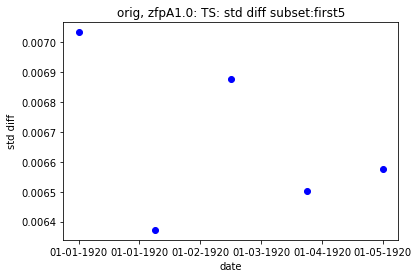

In [21]:
ldcpy.plot(ds, "TS", c0='orig', metric='std', plot_type="time_series", c1="zfpA1.0", metric_type="diff", subset="first5")

Additionally, we can specify lat and lon keywords for time-series plots that give us a subset of the data at a single point, rather than averaging over all latitudes and longitudes. The nearest latitude and longitude point to the one specified is plotted (and the actual coordinates of the point can be found in the plot title). This plot, for example, shows the difference in mean rainfall between the compressed and original data at the location (44.76, -123.75):

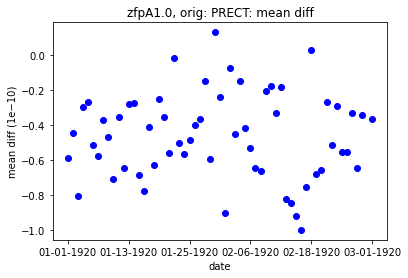

In [22]:
ldcpy.plot(ds2, "PRECT", c0='zfpA1.0', c1='orig', metric_type="diff", metric="mean", plot_type="time_series")

It is also possible to plot metrics for a subset of the data, by specifying the start and end indices of the data we are interested in. This command creates a time-series plot of the mean TS values for the first 45 days of data:

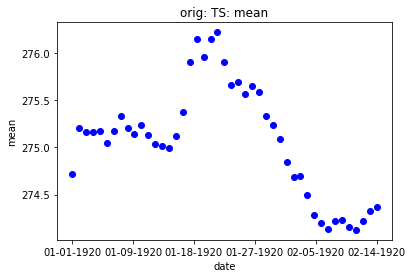

In [24]:
ldcpy.plot(ds, "TS", c0='orig', metric='mean', start=0, end=45, plot_type="time_series")